In [1]:
using Statistics, ControlSystems, LinearAlgebra, Kronecker, SparseArrays, Plots, JuMP, Ipopt, OSQP

# Compile command
run(`gcc N35_BoxQP.c -o N35_BoxQP.so -O3 -march=native -lopenblas -llapacke -shared -fPIC`)
run(`gcc N3_BoxQP_dsyr.c -o N3_BoxQP_dsyr.so -O3 -march=native -lopenblas -llapacke -shared -fPIC`)

# define the interface call
const N35_BoxQP_lib = "./N35_BoxQP.so"
function call_N35_BoxQP(H::Array{Float64,2},h::Array{Float64,1},epsilon::Float64,alpha::Float64)
    n = length(h)
    z = Array{Float64,1}(undef,n)
    ccall(
        (:N35_BoxQP, N35_BoxQP_lib),
        Cvoid,
        (Ptr{Cdouble},Ptr{Cdouble},Cdouble,Cdouble,Cint,Ptr{Cdouble}),
        H,h,epsilon,alpha,n,z
    )
    return z
end

const N3_BoxQP_dsyr_lib = "./N3_BoxQP_dsyr.so"
function call_N3_BoxQP_dsyr(H::Array{Float64,2},h::Array{Float64,1},epsilon::Float64,alpha::Float64,delta::Float64)
    n = length(h)
    z = Array{Float64,1}(undef,n)
    ccall(
        (:N3_BoxQP_dsyr, N3_BoxQP_dsyr_lib),
        Cvoid,
        (Ptr{Cdouble},Ptr{Cdouble},Cdouble,Cdouble,Cdouble,Cint,Ptr{Cdouble}),
        H,h,epsilon,alpha,delta,n,z
    )
    return z
end

call_N3_BoxQP_dsyr (generic function with 1 method)

In [21]:
Ts = 0.05
NSim = 200
Np = 10

# Define the continuous-time model
Ac = [-0.0151 -60.5651 0 -32.174;
      -0.0001 -1.3411 0.9929 0;
      0.00018 43.2541 -0.86939 0;
      0 0 1 0]
Bc = [-2.516 -13.136;
     -0.1689 -0.2514;
     -17.251 -1.5766;
     0 0];
Cc = [0 1 0 0;
      0 0 0 1];
Dc = [0 0;
      0 0];
sys = ss(Ac,Bc,Cc,Dc)
model = c2d(sys, Ts)
nx, nu = size(model.B)
A_aug = [model.A model.B;
         zeros(nu,nx) I(nu)]
B_aug = [model.B;
         I(nu)]
C_aug = [model.C zeros(nu,nu)]

# MPC-to-QP condense construction
Wy = 10 * I(nu)
Wdu = 0.1 * I(nu)
AiB = B_aug
BB = kron(I(Np),AiB)
for i in 1:Np-1
    AiB = A_aug * AiB
    BB += kron(spdiagm(-i=>ones(Np-i)),AiB)
end
QQ = kron(I(Np), C_aug'*Wy*C_aug)
RR = kron(I(Np), Wdu)
Q = BB' * QQ * BB + RR
Q = (Q+Q')/2

E_x = [0 1 0 0 0 0;
       0 0 0 1 0 0;
       0 0 0 0 1 0;
       0 0 0 0 0 1]
G = [kron(I(Np), E_x)*BB; -kron(I(Np), E_x)*BB];

# closed-loop simulation using mine L1-QP solver
ref = [0.0; 10.0]
x = [0; 5; 0; 0] # lies in an infeasible region
u = zeros(nu)
Ref_Hist = ref
U_Hist = Matrix{Float64}(undef, 2, 0)
Y_Hist = model.C*x
Run_time_Hist = []
for k in 1:NSim
    if mod(k,100)==0
        ref = [0.0; 0.0]
    end
    Ref_Hist = [Ref_Hist ref]
    # finish uncompleted MPC-to-QP condense construction
    x0 = [x; u]
    ei = A_aug * x0
    ee = ei
    gg = E_x*ei
    for i in 2:Np
        ei = A_aug * ei
        ee = [ee; ei]
        gg = [gg; E_x*ei]
    end
    c = BB' * (QQ*ee - vec(repeat(C_aug'*Wy*ref, Np, 1)))
    g = [vec(repeat([0.5;100;25;25],Np,1)) - gg; gg - vec(repeat([-0.5;-100;-25;-25],Np,1))]
    # using our ETC-L1-QP solver
    rho = vec(1000 * [repeat([1.0;1.0;10.0;10.0],Np,1); repeat([1.0;1.0;10.0;10.0],Np,1)])
    M = G*inv(Q)*G'
    d = G*inv(Q)*c + g;
    H = Diagonal(rho)*M*Diagonal(rho)
    h = Diagonal(rho)*(M*rho+2*d)
    
    start_time = time()
    sol = call_N3_BoxQP_dsyr(H,h,1e-6,0.3,0.15)
    run_time = time() - start_time
    Run_time_Hist = [Run_time_Hist; run_time]
    dU = -inv(Q)*(c+0.5*G'*(rho.*sol+rho))
    # apply the first control input
    u = u + dU[1:nu]
    x = model.A * x + model.B * u
    U_Hist = hcat(U_Hist, u)
    Y_Hist = [Y_Hist model.C*x]
end
computation_time = mean(Run_time_Hist)
println("The average computation of our N3QP solver is $computation_time seconds")

computation_time = maximum(Run_time_Hist)
println("The worsr-case computation of our N3QP solver is $computation_time seconds")

The average computation of our N3QP solver is 0.06424434423446655 seconds
The worsr-case computation of our N3QP solver is 0.10822391510009766 seconds


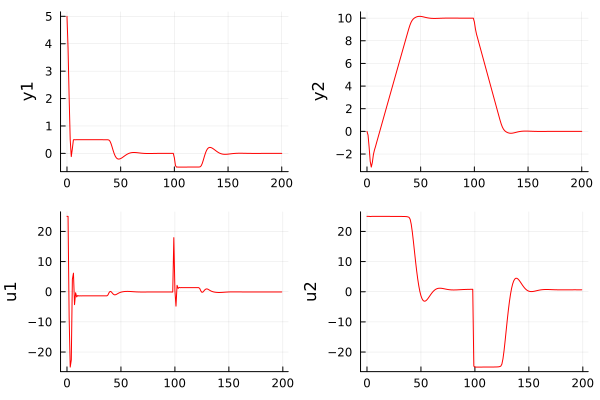

In [3]:
plot_layout = @layout [a b; c d]
p = plot(layout = plot_layout)
plot!(p, 0:NSim, Y_Hist[1,:], label=false, color=:red, linewidth=1,ylabel="y1",subplot=1)
plot!(p, 0:NSim, Y_Hist[2,:], label=false, color=:red, linewidth=1,ylabel="y2",subplot=2)
plot!(p, 0:NSim-1, U_Hist[1,:], label=false, color=:red, linewidth=1,ylabel="u1",subplot=3)
plot!(p, 0:NSim-1, U_Hist[2,:], label=false, color=:red, linewidth=1,ylabel="u2",subplot=4)

In [26]:
# calculting the computation time of N35_QP solver
Ts = 0.05
NSim = 200
Np = 10

# Define the continuous-time model
Ac = [-0.0151 -60.5651 0 -32.174;
      -0.0001 -1.3411 0.9929 0;
      0.00018 43.2541 -0.86939 0;
      0 0 1 0]
Bc = [-2.516 -13.136;
     -0.1689 -0.2514;
     -17.251 -1.5766;
     0 0];
Cc = [0 1 0 0;
      0 0 0 1];
Dc = [0 0;
      0 0];
sys = ss(Ac,Bc,Cc,Dc)
model = c2d(sys, Ts)
nx, nu = size(model.B)
A_aug = [model.A model.B;
         zeros(nu,nx) I(nu)]
B_aug = [model.B;
         I(nu)]
C_aug = [model.C zeros(nu,nu)]

# MPC-to-QP condense construction
Wy = 10 * I(nu)
Wdu = 0.1 * I(nu)
AiB = B_aug
BB = kron(I(Np),AiB)
for i in 1:Np-1
    AiB = A_aug * AiB
    BB += kron(spdiagm(-i=>ones(Np-i)),AiB)
end
QQ = kron(I(Np), C_aug'*Wy*C_aug)
RR = kron(I(Np), Wdu)
Q = BB' * QQ * BB + RR
Q = (Q+Q')/2

E_x = [0 1 0 0 0 0;
       0 0 0 1 0 0;
       0 0 0 0 1 0;
       0 0 0 0 0 1]
G = [kron(I(Np), E_x)*BB; -kron(I(Np), E_x)*BB];

# closed-loop simulation using mine L1-QP solver
ref = [0.0; 10.0]
x = [0; 5; 0; 0] # lies in an infeasible region
u = zeros(nu)
Ref_Hist = ref
U_Hist = Matrix{Float64}(undef, 2, 0)
Y_Hist = model.C*x
Run_time_Hist = []
for k in 1:NSim
    if mod(k,100)==0
        ref = [0.0; 0.0]
    end
    Ref_Hist = [Ref_Hist ref]
    # finish uncompleted MPC-to-QP condense construction
    x0 = [x; u]
    ei = A_aug * x0
    ee = ei
    gg = E_x*ei
    for i in 2:Np
        ei = A_aug * ei
        ee = [ee; ei]
        gg = [gg; E_x*ei]
    end
    c = BB' * (QQ*ee - vec(repeat(C_aug'*Wy*ref, Np, 1)))
    g = [vec(repeat([0.5;100;25;25],Np,1)) - gg; gg - vec(repeat([-0.5;-100;-25;-25],Np,1))]
    
    rho = vec(1000 * [repeat([1.0;1.0;10.0;10.0],Np,1); repeat([1.0;1.0;10.0;10.0],Np,1)])
    M = G*inv(Q)*G'
    d = G*inv(Q)*c + g;
    H = Diagonal(rho)*M*Diagonal(rho)
    h = Diagonal(rho)*(M*rho+2*d)
    
    start_time = time()
    sol = call_N35_BoxQP(H,h,1e-6,0.3)
    run_time = time() - start_time
    Run_time_Hist = [Run_time_Hist; run_time]
    dU = -inv(Q)*(c+0.5*G'*(rho.*sol+rho))
    # apply the first control input
    u = u + dU[1:nu]
    x = model.A * x + model.B * u
    U_Hist = hcat(U_Hist, u)
    Y_Hist = [Y_Hist model.C*x]
end
computation_time = mean(Run_time_Hist)
println("The average computation of our N35QP solver is $computation_time seconds")

computation_time = maximum(Run_time_Hist)
println("The worsr-case computation of our N35QP solver is $computation_time seconds")

The average computation of our N35QP solver is 0.1498088026046753 seconds
The worsr-case computation of our N35QP solver is 0.3137209415435791 seconds


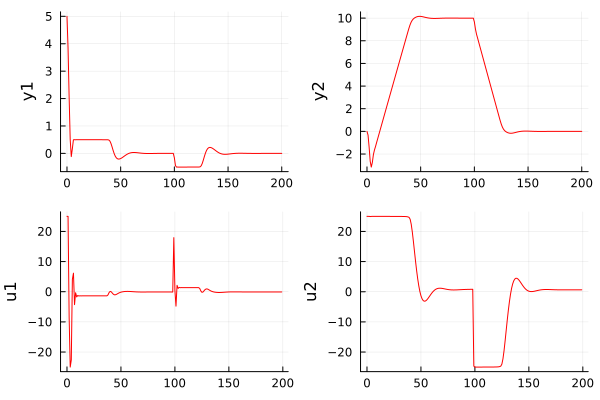

In [5]:
plot_layout = @layout [a b; c d]
p = plot(layout = plot_layout)
plot!(p, 0:NSim, Y_Hist[1,:], label=false, color=:red, linewidth=1,ylabel="y1",subplot=1)
plot!(p, 0:NSim, Y_Hist[2,:], label=false, color=:red, linewidth=1,ylabel="y2",subplot=2)
plot!(p, 0:NSim-1, U_Hist[1,:], label=false, color=:red, linewidth=1,ylabel="u1",subplot=3)
plot!(p, 0:NSim-1, U_Hist[2,:], label=false, color=:red, linewidth=1,ylabel="u2",subplot=4)

In [29]:
# calculate the computationtime of Ipopt solver

Ts = 0.05
NSim = 200
Np = 10

# Define the continuous-time model
Ac = [-0.0151 -60.5651 0 -32.174;
      -0.0001 -1.3411 0.9929 0;
      0.00018 43.2541 -0.86939 0;
      0 0 1 0]
Bc = [-2.516 -13.136;
     -0.1689 -0.2514;
     -17.251 -1.5766;
     0 0];
Cc = [0 1 0 0;
      0 0 0 1];
Dc = [0 0;
      0 0];
sys = ss(Ac,Bc,Cc,Dc)
model = c2d(sys, Ts)
nx, nu = size(model.B)
A_aug = [model.A model.B;
         zeros(nu,nx) I(nu)]
B_aug = [model.B;
         I(nu)]
C_aug = [model.C zeros(nu,nu)]

# MPC-to-QP condense construction
Wy = 10 * I(nu)
Wdu = 0.1 * I(nu)
AiB = B_aug
BB = kron(I(Np),AiB)
for i in 1:Np-1
    AiB = A_aug * AiB
    BB += kron(spdiagm(-i=>ones(Np-i)),AiB)
end
QQ = kron(I(Np), C_aug'*Wy*C_aug)
RR = kron(I(Np), Wdu)
Q = BB' * QQ * BB + RR
Q = (Q+Q')/2

E_x = [0 1 0 0 0 0;
       0 0 0 1 0 0;
       0 0 0 0 1 0;
       0 0 0 0 0 1]
G = [kron(I(Np), E_x)*BB; -kron(I(Np), E_x)*BB];

# closed-loop simulation using mine L1-QP solver
ref = [0.0; 10.0]
x = [0; 5; 0; 0] # lies in an infeasible region
u = zeros(nu)
Ref_Hist = ref
U_Hist = Matrix{Float64}(undef, 2, 0)
Y_Hist = model.C*x
Run_time_Hist = []
for k in 1:NSim
    if mod(k,100)==0
        ref = [0.0; 0.0]
    end
    Ref_Hist = [Ref_Hist ref]
    # finish uncompleted MPC-to-QP condense construction
    x0 = [x; u]
    ei = A_aug * x0
    ee = ei
    gg = E_x*ei
    for i in 2:Np
        ei = A_aug * ei
        ee = [ee; ei]
        gg = [gg; E_x*ei]
    end
    c = BB' * (QQ*ee - vec(repeat(C_aug'*Wy*ref, Np, 1)))
    g = [vec(repeat([0.5;100;25;25],Np,1)) - gg; gg - vec(repeat([-0.5;-100;-25;-25],Np,1))]
    
    rho = vec(1000 * [repeat([1.0;1.0;10.0;10.0],Np,1); repeat([1.0;1.0;10.0;10.0],Np,1)])
    M = G*inv(Q)*G'
    d = G*inv(Q)*c + g;
    H = Diagonal(rho)*M*Diagonal(rho)
    h = Diagonal(rho)*(M*rho+2*d)
    
    model_ipopt = Model(Ipopt.Optimizer)
    set_attribute(model_ipopt,"print_level",0)
    @variable(model_ipopt,-1.0<=z[i=1:length(h)]<=1.0)
    @objective(model_ipopt,Min,0.5*z'*H*z+h'*z)
    start_time = time()
    optimize!(model_ipopt)
    run_time = time() - start_time
    sol = value(z)

    Run_time_Hist = [Run_time_Hist; run_time]
    dU = -inv(Q)*(c+0.5*G'*(rho.*sol+rho))
    # apply the first control input
    u = u + dU[1:nu]
    x = model.A * x + model.B * u
    U_Hist = hcat(U_Hist, u)
    Y_Hist = [Y_Hist model.C*x]
end
computation_time = mean(Run_time_Hist)
println("The average computation of Ipopt solver is $computation_time seconds")

computation_time = maximum(Run_time_Hist)
println("The worst-case computation of Ipopt solver is $computation_time seconds")

The average computation of Ipopt solver is 0.004506468772888184 seconds
The worst-case computation of Ipopt solver is 0.04036116600036621 seconds


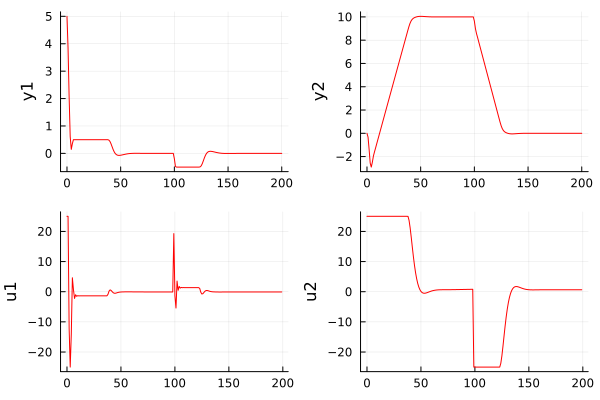

In [7]:
plot_layout = @layout [a b; c d]
p = plot(layout = plot_layout)
plot!(p, 0:NSim, Y_Hist[1,:], label=false, color=:red, linewidth=1,ylabel="y1",subplot=1)
plot!(p, 0:NSim, Y_Hist[2,:], label=false, color=:red, linewidth=1,ylabel="y2",subplot=2)
plot!(p, 0:NSim-1, U_Hist[1,:], label=false, color=:red, linewidth=1,ylabel="u1",subplot=3)
plot!(p, 0:NSim-1, U_Hist[2,:], label=false, color=:red, linewidth=1,ylabel="u2",subplot=4)

In [34]:
# get the computationtime of OSQP solver

Ts = 0.05
NSim = 200
Np = 10

# Define the continuous-time model
Ac = [-0.0151 -60.5651 0 -32.174;
      -0.0001 -1.3411 0.9929 0;
      0.00018 43.2541 -0.86939 0;
      0 0 1 0]
Bc = [-2.516 -13.136;
     -0.1689 -0.2514;
     -17.251 -1.5766;
     0 0];
Cc = [0 1 0 0;
      0 0 0 1];
Dc = [0 0;
      0 0];
sys = ss(Ac,Bc,Cc,Dc)
model = c2d(sys, Ts)
nx, nu = size(model.B)
A_aug = [model.A model.B;
         zeros(nu,nx) I(nu)]
B_aug = [model.B;
         I(nu)]
C_aug = [model.C zeros(nu,nu)]

# MPC-to-QP condense construction
Wy = 10 * I(nu)
Wdu = 0.1 * I(nu)
AiB = B_aug
BB = kron(I(Np),AiB)
for i in 1:Np-1
    AiB = A_aug * AiB
    BB += kron(spdiagm(-i=>ones(Np-i)),AiB)
end
QQ = kron(I(Np), C_aug'*Wy*C_aug)
RR = kron(I(Np), Wdu)
Q = BB' * QQ * BB + RR
Q = (Q+Q')/2

E_x = [0 1 0 0 0 0;
       0 0 0 1 0 0;
       0 0 0 0 1 0;
       0 0 0 0 0 1]
G = [kron(I(Np), E_x)*BB; -kron(I(Np), E_x)*BB];

# closed-loop simulation using mine L1-QP solver
ref = [0.0; 10.0]
x = [0; 5; 0; 0] # lies in an infeasible region
u = zeros(nu)
Ref_Hist = ref
U_Hist = Matrix{Float64}(undef, 2, 0)
Y_Hist = model.C*x
Run_time_Hist = []
model_osqp = OSQP.Model()
for k in 1:NSim
    if mod(k,100)==0
        ref = [0.0; 0.0]
    end
    Ref_Hist = [Ref_Hist ref]
    # finish uncompleted MPC-to-QP condense construction
    x0 = [x; u]
    ei = A_aug * x0
    ee = ei
    gg = E_x*ei
    for i in 2:Np
        ei = A_aug * ei
        ee = [ee; ei]
        gg = [gg; E_x*ei]
    end
    c = BB' * (QQ*ee - vec(repeat(C_aug'*Wy*ref, Np, 1)))
    g = [vec(repeat([0.5;100;25;25],Np,1)) - gg; gg - vec(repeat([-0.5;-100;-25;-25],Np,1))]
    
    rho = vec(1000 * [repeat([1.0;1.0;10.0;10.0],Np,1); repeat([1.0;1.0;10.0;10.0],Np,1)])
    H = G*inv(Q)*G'
    h = G*inv(Q)*c + g;
    
    OSQP.setup!(model_osqp; P=sparse(H), q=h, A=sparse(Diagonal(ones(length(h)))),l=zeros(length(h)),u=rho,eps_abs=1e-6,eps_rel=1e-6,verbose=0)
    start_time = time()
    results = OSQP.solve!(model_osqp)
    run_time = time() - start_time
    sol = results.x

    Run_time_Hist = [Run_time_Hist; run_time]
    dU = -inv(Q)*(c+G'*sol)
    # apply the first control input
    u = u + dU[1:nu]
    x = model.A * x + model.B * u
    U_Hist = hcat(U_Hist, u)
    Y_Hist = [Y_Hist model.C*x]
end
computation_time = mean(Run_time_Hist)
println("The average computation of OSQP solver is $computation_time seconds")

computation_time = maximum(Run_time_Hist)
println("The worst-case computation of OSQP solver is $computation_time seconds")

The average computation of OSQP solver is 0.007633311748504639 seconds
The worst-case computation of OSQP solver is 0.02621603012084961 seconds


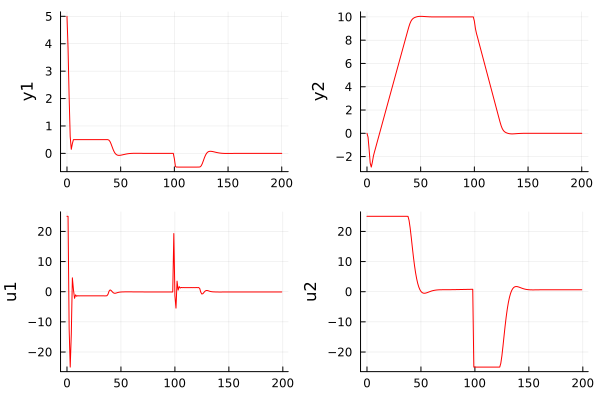

In [9]:
plot_layout = @layout [a b; c d]
p = plot(layout = plot_layout)
plot!(p, 0:NSim, Y_Hist[1,:], label=false, color=:red, linewidth=1,ylabel="y1",subplot=1)
plot!(p, 0:NSim, Y_Hist[2,:], label=false, color=:red, linewidth=1,ylabel="y2",subplot=2)
plot!(p, 0:NSim-1, U_Hist[1,:], label=false, color=:red, linewidth=1,ylabel="u1",subplot=3)
plot!(p, 0:NSim-1, U_Hist[2,:], label=false, color=:red, linewidth=1,ylabel="u2",subplot=4)